In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("asm_full_opt")
sys.path.append("data")

from pixel_map import PixelMap
from asm_prop import ASMPropagator
import config

In [2]:
pm = PixelMap(config)

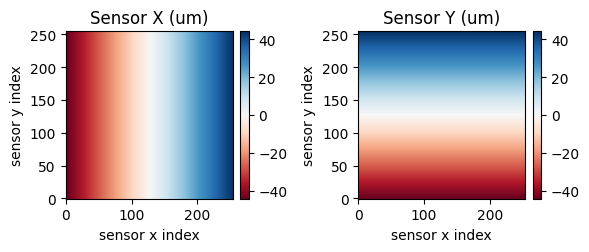

In [3]:
X = pm.X.detach().cpu()
Y = pm.Y.detach().cpu()

unit_scale = 1e6   
unit_name  = "um"

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

im0 = axs[0].imshow(
    X.T * unit_scale,
    origin="lower",
    cmap="RdBu"
)
axs[0].set_title(f"Sensor X ({unit_name})")
axs[0].set_xlabel("sensor x index")
axs[0].set_ylabel("sensor y index")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(
    Y.T * unit_scale,
    origin="lower",
    cmap="RdBu"
)
axs[1].set_title(f"Sensor Y ({unit_name})")
axs[1].set_xlabel("sensor x index")
axs[1].set_ylabel("sensor y index")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


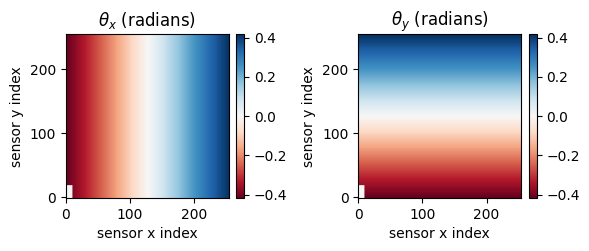

In [4]:
theta_x, theta_y = pm.sensor_xy_to_angles()
theta_x[0:10, 0:20] = 0
theta_y[0:10, 0:20] = 0

theta_x_cpu = theta_x.detach().cpu()
theta_y_cpu = theta_y.detach().cpu()

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

im0 = axs[0].imshow(theta_x_cpu.T, cmap="RdBu", origin="lower")
axs[0].set_title(r"$\theta_x$ (radians)")
axs[0].set_xlabel("sensor x index")
axs[0].set_ylabel("sensor y index")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(theta_y_cpu.T, origin="lower", cmap="RdBu")
axs[1].set_title(r"$\theta_y$ (radians)")
axs[1].set_xlabel("sensor x index")
axs[1].set_ylabel("sensor y index")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

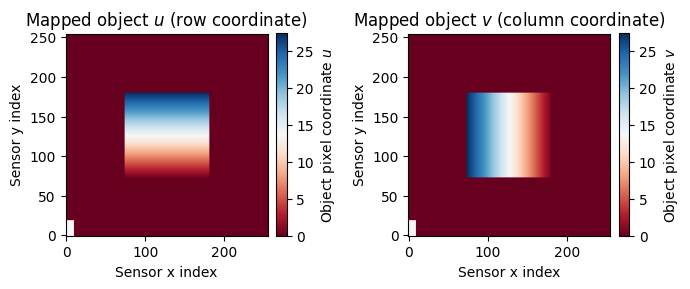

In [5]:
u, v, valid = pm.angles_to_object_pix(theta_x, theta_y)

u_cpu = u.detach().cpu()
v_cpu = v.detach().cpu()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

im0 = axs[0].imshow(
    u_cpu.T,
    origin="lower",
    cmap="RdBu"
)
axs[0].set_title(r"Mapped object $u$ (row coordinate)")
axs[0].set_xlabel("Sensor x index")
axs[0].set_ylabel("Sensor y index")
cbar0 = plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
cbar0.set_label("Object pixel coordinate $u$")

im1 = axs[1].imshow(
    v_cpu.T,
    origin="lower",
    cmap="RdBu"
)
axs[1].set_title(r"Mapped object $v$ (column coordinate)")
axs[1].set_xlabel("Sensor x index")
axs[1].set_ylabel("Sensor y index")
cbar1 = plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
cbar1.set_label("Object pixel coordinate $v$")

plt.tight_layout()
plt.show()


Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


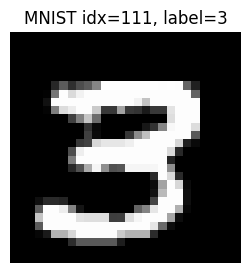

In [6]:
import torch
from torchvision.datasets import MNIST

# Load MNIST from your existing ./data folder (no download)
ds = MNIST(root="./data", train=True, download=False)

# Choose how many images to batch
N_batch = 10
idx0 = 111   # starting index

# Stack N_batch images into a batch
imgs = []
labels = []
for i in range(N_batch):
    x_pil, y = ds[idx0 + i]
    imgs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
    labels.append(y)

imgs = torch.stack(imgs, dim=0)   # [N,28,28]

print("Loaded batch:", imgs.shape)
print("Labels (first 10):", labels[:10])

# Show ONE image from the batch
show_idx = 0
plt.figure(figsize=(3,3))
plt.imshow(imgs[show_idx], cmap="gray", vmin=0, vmax=1)
plt.title(f"MNIST idx={idx0+show_idx}, label={labels[show_idx]}")
plt.axis("off")
plt.show()


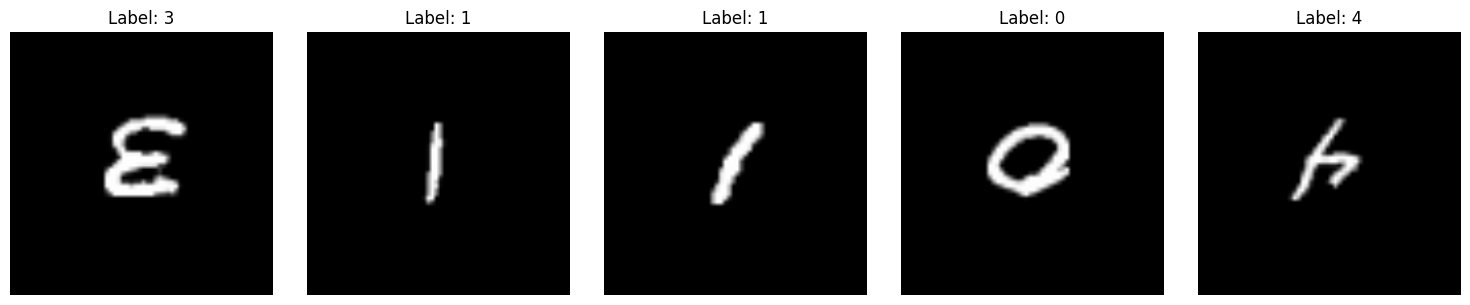

In [7]:
pm.build_obj_sampling_grid(transpose_sensor_grid=True, store=True)
sensor_ideal = pm.render_sensor_ideal(imgs)

# sensor_ideal: [B, 1, N, N]
num_show = min(5, sensor_ideal.shape[0])

fig, axs = plt.subplots(1, 5, figsize=(3*num_show, 3))
axs = axs.flatten()

for i in range(num_show):
    axs[i].imshow(
        sensor_ideal[i, 0].detach().cpu(),
        origin="lower",
        cmap="gray",
    )
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis("off")

# Hide any unused axes
for j in range(num_show, 5):
    axs[j].axis("off")

plt.tight_layout()
plt.show()



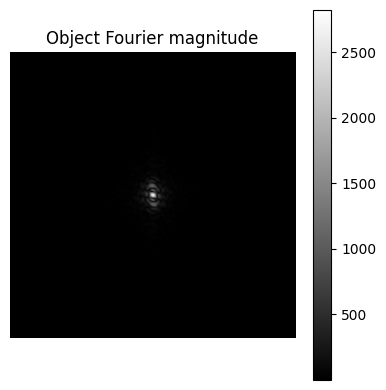

In [14]:
# Take one sensor image
img0 = sensor_ideal[0, 0].detach().cpu()

# Fourier transform
F = torch.fft.fft2(img0)
F = torch.fft.fftshift(F)          # center DC for visualization

# Magnitude spectrum
mag = torch.abs(F)

plt.figure(figsize=(4,4))
plt.imshow(
    mag,
    origin="lower",
    cmap="gray"
)
plt.title("Object Fourier magnitude")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()